Maria Musiał 156062

# Computer vision - Lab 4

## Agenda


*   Binary morphology,
*   Grayscale morphology,
*   Morphological operations as a tool to segmentation




## Helpers

To perform the tasks, it is necessary to import the libraries used in the script and download the data on which we will be working.

In this script we will be using:
* SuperNova image - photo of a star explosion in space ([link](https://upload.wikimedia.org/wikipedia/commons/b/bd/G299-Remnants-SuperNova-Type1a-20150218.jpg))

In [3]:
# importing of libraires that will be use in the script
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL

%matplotlib inline
import json
import os

import pandas as pd
import plotly.graph_objects as go
from IPython.display import HTML, display
from pandas import DataFrame
from scipy.ndimage import binary_hit_or_miss
from skimage.exposure import rescale_intensity

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# download image
# !wget -O supernova.png https://upload.wikimedia.org/wikipedia/commons/b/bd/G299-Remnants-SuperNova-Type1a-20150218.jpg
#!wget -O binary_images.png https://vision.lems.brown.edu/sites/default/files/images/binary_images.png - download this file from e-Kursy site

The colab platform requires a special way to display images with opencv. If the notebook is run in collab, execute the following code:

In [49]:
def plt_imshow(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()
    
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        plt_imshow(img)
        # cv2.imshow("ImageWindow", img)
        # cv2.waitKey()
        # cv2.destroyAllWindows()


In [50]:
def show_binary(a, interpolation=None, cmap="gray"):
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False,
        left=False,
        right=False,
    )
    plt.imshow(a, cmap=cmap, interpolation=interpolation)
    plt.show()


def h_color(a, interpolation=None, size=None, fy=1.5, fx=1.5, cmap="gray"):
    s = [int(a.shape[0] * fy), int(a.shape[1] * fx)] if size is None else size
    plt.figure(figsize=s)
    show_binary(a, interpolation, cmap)

In [51]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td {
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""


def h(s):
    return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))


In [52]:
def h_color_3d(z):
    fig = go.Figure(data=[go.Surface(z=z)])
    fig.update_layout(autosize=False, width=500, height=500)
    fig.show()


# Morphological operations


A morphological operation is a binary image processing technique that modifies the input image (e.g. by switching on or off a pixel bit) based on **matching** the pixel's surroundings with a **structuring element**.

The above definition of a morphological operation requires the clarification of certain terms:
* **structuring element** - a bitmask that specifies the structure that we are looking for in the image. Referring to the convolution operation, it is an equivalent of the matched function to the input image (e.g. laplacian, derivative),
* **matching** - compliance of the structuring element with the selected pixel and its neighbourhood, dimensionally corresponding to the structuring element. Can be represented as a bitmask with the size of a structuring element,
* the morphological operation is similar to the convolution - also a certain function is matched to the input image, however, to modify a given pixel, certain conditions must be met.

Basic operators:
*  **Erosion** -  if **all** components of a structuring element and the corresponding neighbourhood of a pixel are the same, the pixel is switched on. Otherwise, switch off. In other words, the match contains **only 1**.

*  **Dilation** -if **any** components of a structuring element and the corresponding neighbourhood of a pixel are the same, the pixel is switched on. Otherwise, switch off.  In other words, the match contains **at least one 1**.

* **Opening** - dilation preceded by erosion, (dilation (erosion (image))

* **Closure** - erosion preceded by dilation, (erosion (dilation (image))



## Binary image

Let us consider an example binary image and a simple structuring element of size (3x3) filled with all bits set to 1, except for those in the second column, which are set to 0.

Structuring element:


0,0,0
1,1,0
0,0,0


Input image:


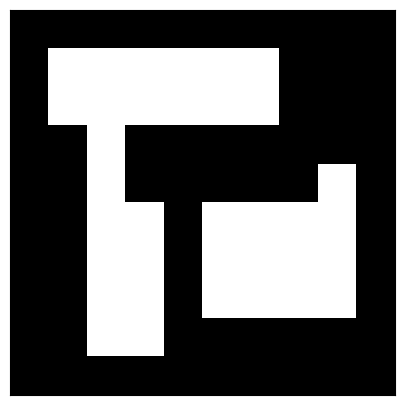

In [53]:
img_bin = np.zeros((10, 10), np.uint8)
img_bin[1:3, 1:7] = 1
img_bin[5:9, 2:4] = 1
img_bin[5:8, 5:9] = 1
img_bin[3:5, 2] = 1
img_bin[4, 8] = 1

struct = np.array([[0,0,0],[1,1,0],[0,0,0]], np.uint8)


print("Structuring element:")
h(struct)

print("Input image:")
h_color(img_bin, fx=0.5, fy=0.5)


### Erosion and dilation

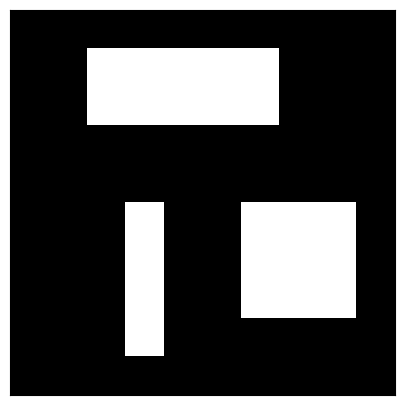

In [54]:
img_bin_ero = cv2.erode(img_bin, struct, iterations=1)
h_color(img_bin_ero, fx=0.5, fy=0.5)

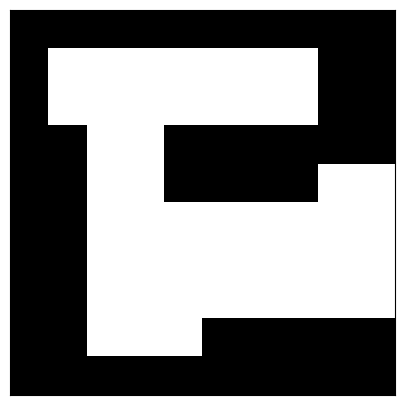

In [55]:
img_bin_dil = cv2.dilate(img_bin, struct, iterations=1)
h_color(img_bin_dil, fx=0.5, fy=0.5)

#### Task 1

Implement the erosion and dilation operation:

The matching of the corresponding pixels in the structuring element and the image should be done as follows:
* for a component of a structuring element 0, the corresponding pixel in the image is ignored during matching This means that in erosion, matching always occurs, as the 0 components do not affect the result, while in dilation, matching never occurs for these positions, as the 0 components are excluded from consideration.
* for the component of the structuring element 1, matching is true if the input image is also 1,
* for a component of structure element -1, matching occurs if the input image is 0.

That is, for a structuring element:


$$s = \begin{bmatrix}
0 & 1 & 0\\
1 & -1 & 1\\
-1 & 0 & -1\\
\end{bmatrix}$$

and image:

$$I = \begin{bmatrix}
0 & 0 & 0\\
1 & 1 & 1\\
0 & 1 & 0\\
\end{bmatrix}$$

the matching matrix will look like:

$$d = \begin{bmatrix}
1 & 0 & 1\\
1 & 0 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$

so the result of the dilation for such a image and structuring element will be 1 (because there is at least one match), and for erosion 0 (because not all pixels are matched).

**Note**: Use the matrix operations presented in lab 1. Don't use loops that iterate over each pixel and functions: np.apply_along_axis and np.vectorize.

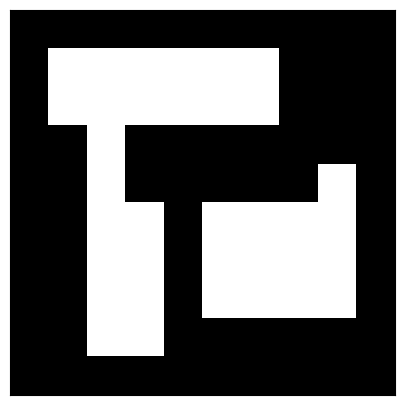

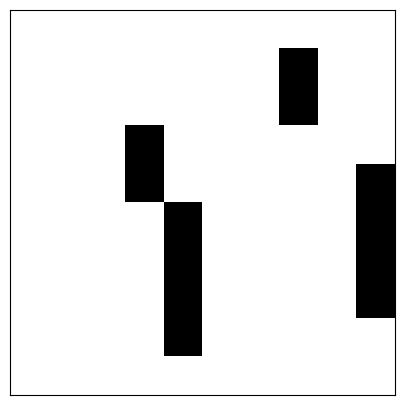

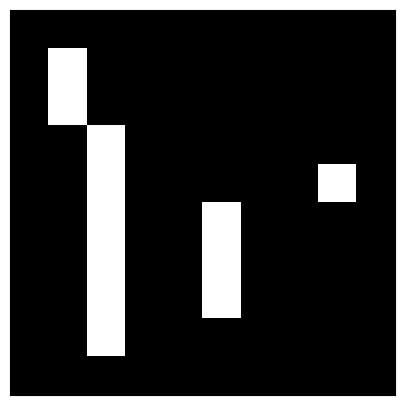

In [56]:
from numpy.lib.stride_tricks import sliding_window_view

def dilate(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
  
  pad_size = struct.shape[0] // 2
  img_padded = np.pad(img, pad_width=(pad_size,), mode='constant', constant_values=(0, 0))

  windows = sliding_window_view(img_padded, struct.shape)
  
  match_ones = struct == 1
  match_zeros = struct == -1
  # Dilation: for each window, if any of the masked positions are 1, set to 1
  ones_match = np.any(windows[..., match_ones] == 1, axis=-1)
  zeros_match = np.all(windows[..., match_zeros] == 0, axis=-1)
    
  result = ones_match | zeros_match
    
  return result.astype(np.uint8)


def erode(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
  pad_size = struct.shape[0] // 2
  img_padded = np.pad(img, pad_width=(pad_size,), mode='constant', constant_values=(0, 0))
  
  windows = sliding_window_view(img_padded, struct.shape)
  
  match_ones = struct == 1
  match_zeros = struct == -1
  # Erosion: for each window, if all of the masked positions are 1, set to 1
  ones_match = np.all(windows[..., match_ones] == 1, axis=-1)
  zeros_match = np.all(windows[..., match_zeros] == 0, axis=-1)

  result = ones_match & zeros_match
    
  return result.astype(np.uint8)


struct = np.array([[0,0,0],[-1,1,0],[0,0,0]], np.int8)
h_color(img_bin, fx=0.5, fy=0.5)
h_color(dilate(img_bin, struct), fx=0.5, fy=0.5)
h_color(erode(img_bin, struct), fx=0.5, fy=0.5)

### Opening and Closing

The intuition behind the opening operation is to try to disconnect areas that are *weakly* connected. By *weakly* you can understand noise or ordinary artefacts produced during image processing.

The use of the opening operation can be found in a situation where we perform segmentation of objects and as a result, we get two objects of the same class next to each other. These objects can be combined by single pixels. To separate these objects from each other (for the so-called **instance segmentation**) we can use the morphological opening.

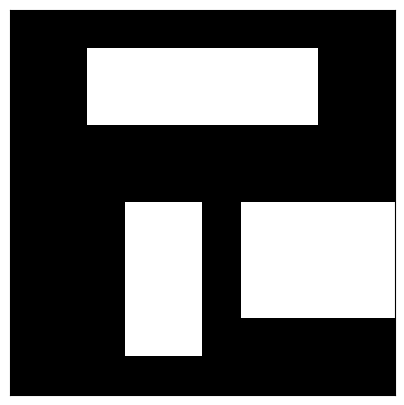

In [57]:
struct = struct.astype(np.uint8)
img_bin_ero = cv2.erode(img_bin, struct, iterations=1)
img_bin_ero_dil = cv2.dilate(img_bin_ero, struct, iterations=1)

h_color(img_bin_ero_dil, fx=0.5, fy=0.5)

Closing intends to connect areas close to each other but due to noise or artefacts, they are disjoint. In the example below, the two regions are close to each other, so they may represent the same object. The closing operation will connect these areas.

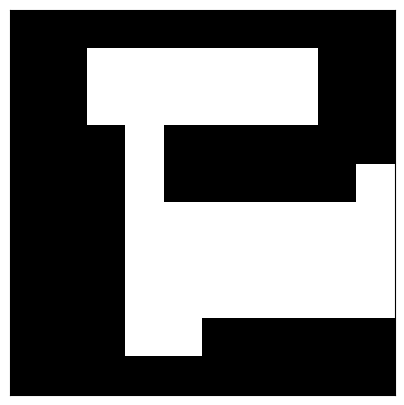

In [58]:
img_bin_dil = cv2.dilate(img_bin, struct, iterations=1)
img_bin_dil_ero = cv2.erode(img_bin_dil, struct, iterations=1)

h_color(img_bin_dil_ero, fx=0.5, fy=0.5)


### Proper opening, proper closing, automedian filter

For the above-mentioned definitions of opening and closing, we can define the following morphological operations:


* $Q(f) = \min(f, C(O(C(f))))$ - proper opening
* $G(f) = \max(f, O(C(O(f))))$ - proper closing
* $A(f) = \max(O(C(O(f))), Q(f))$ - automedian filter

For the image below, arbitrarily adopted binarization will be performed for further processing with morphological operations.

The supernova shown in this image has many details in the form of other galaxies that resemble artificially added noise. The purpose of the following processing will be to detect areas where there is a supernova, while eliminating areas that do not belong to the object.


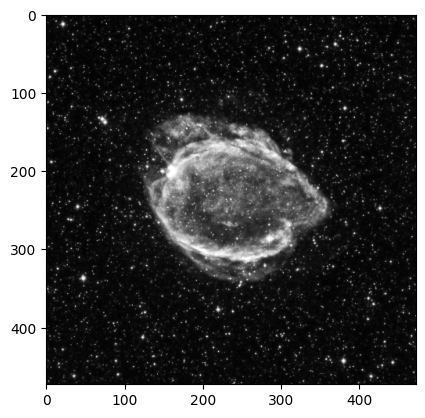

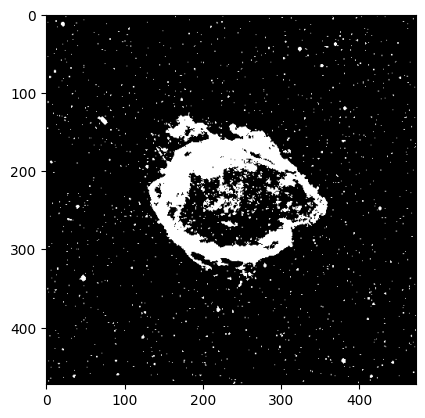

In [59]:
img_space_raw = cv2.imread("./supernova.png", 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)
img_space = (img_space_raw > 100).astype(np.uint8) * 255

struct = np.ones([5, 5], np.uint8)
imshow(img_space_raw)
imshow(img_space)


Recall that the proper opening operation consists of 3 successive operations: closing, opening and closing again. The result is compared with the **input image**, and the result is a **min** operation on the input image and the result of the sequence of operations.

The proper opening result can be interpreted as **selecting a coherent area from the input image keeping the details of the input image.**



Intermediate results



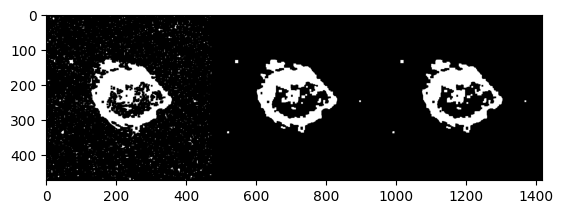


Comparison of the input image and result of the proper opening



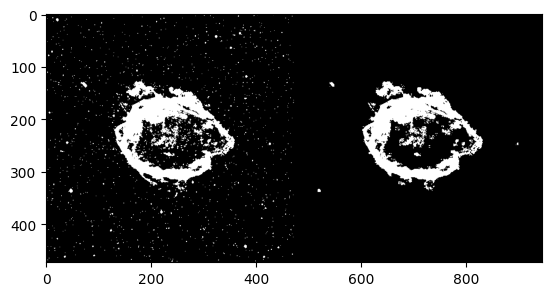

In [60]:
img_space_close = cv2.morphologyEx(img_space, cv2.MORPH_CLOSE, struct)
img_space_open = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_close2 = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)
img_space_Q = np.minimum(img_space, img_space_close2)

print("\nIntermediate results\n")
imshow(np.concatenate([img_space_close, img_space_open, img_space_close2], 1))

print("\nComparison of the input image and result of the proper opening\n")
imshow(np.concatenate([img_space, img_space_Q], 1))


A proper closing operation consists of successive open, close, and open operations.

The results can be interpreted as an input image **with the uniform area** highlighted.


Intermediate results



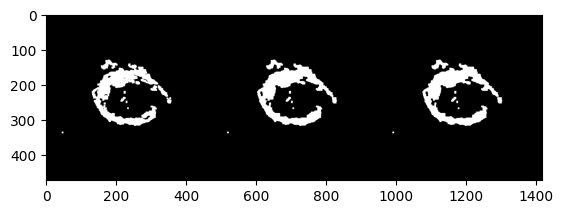


Comparison of the input image and result of the proper closing 



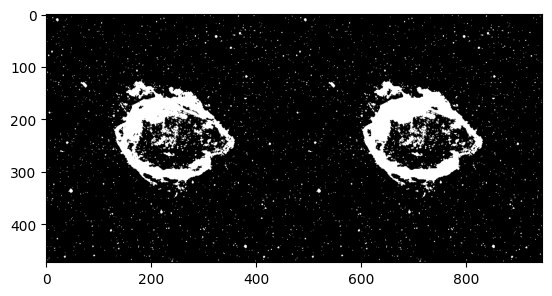

In [61]:
img_space_open = cv2.morphologyEx(img_space, cv2.MORPH_OPEN, struct)
img_space_close = cv2.morphologyEx(img_space_open, cv2.MORPH_CLOSE, struct)
img_space_open2 = cv2.morphologyEx(img_space_close, cv2.MORPH_OPEN, struct)
img_space_G = np.maximum(img_space, img_space_open2)

print("\nIntermediate results\n")
imshow(np.concatenate([img_space_open, img_space_close, img_space_open2], 1))

print("\nComparison of the input image and result of the proper closing \n")
imshow(np.concatenate([img_space, img_space_G], 1))


#### Task 2

**2.1)** Implement the **automedians filter** operation and test it on a previously processed supernova image (in binary space). You can use the functions available in OpenCV (cv2.morphologyEx).

**2.2)** Describe the **similarities** and **differences** between the result of the automedian operation and the image produced by the proper opening and the proper closing.


Comparison of the input image and automedians filter



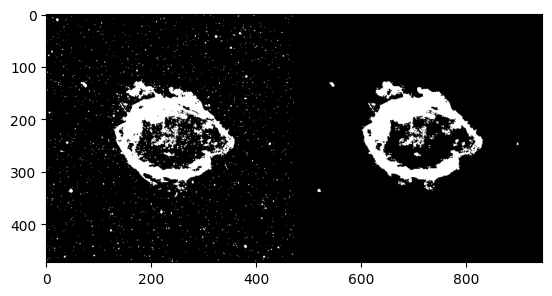

In [69]:
img_space_open_a = cv2.morphologyEx(img_space, cv2.MORPH_OPEN, struct)
img_space_close_a = cv2.morphologyEx(img_space_open_a, cv2.MORPH_CLOSE, struct)
img_space_open_a2 = cv2.morphologyEx(img_space_close_a, cv2.MORPH_CLOSE, struct)
img_space_automedian = np.maximum(img_space_open_a2, img_space_Q)


print("\nComparison of the input image and automedians filter\n")
imshow(np.concatenate([img_space, img_space_automedian], 1))
# imshow(np.concatenate([img_space, img_space_automedian, img_space_G, img_space_Q], 1))


Comparison of the results obtained from automedian and proper opening:

### Similarities and Differences between Automedian Operation and Proper Opening/Closing

**Similarities** between automedian and closing\opening
- Automedian reduces salt'n'pepper noise like opening
- Automedian closes gaps and cavities like closing
- All used in binary image processing

**Differences**
- **Different targeted noise**
    - Automedian: targets salt'n'pepper and gaps
    - Opening: targets small objects and salt'n'pepper noise
    - Closing: targets small holes and gaps
- **Effect**
    - Automedian: retains edges while smoothing
    - Opening: Breaks narrow connections and removes small objects
    - Closing: Merges close objects and fills cavities
- **Sequence** of operations

In [68]:
cv2.imshow("ImageWindow", np.concatenate([img_space, img_space_automedian, img_space_G, img_space_Q], 1))
cv2.waitKey()
cv2.destroyAllWindows()

## Morphological operations as simple pattern recognition

Morphological operations are operations based on logical operations. This implies some practical applications in image processing and, in particular, pattern recognition.

In general, the structural element need not be a simple element that makes erosion and dilation results larger / smaller areas. The structural element can take a more complex form and correspond to some of the sought features in the image.

Let's define a more sophisticated binary image containing some repeating patterns.



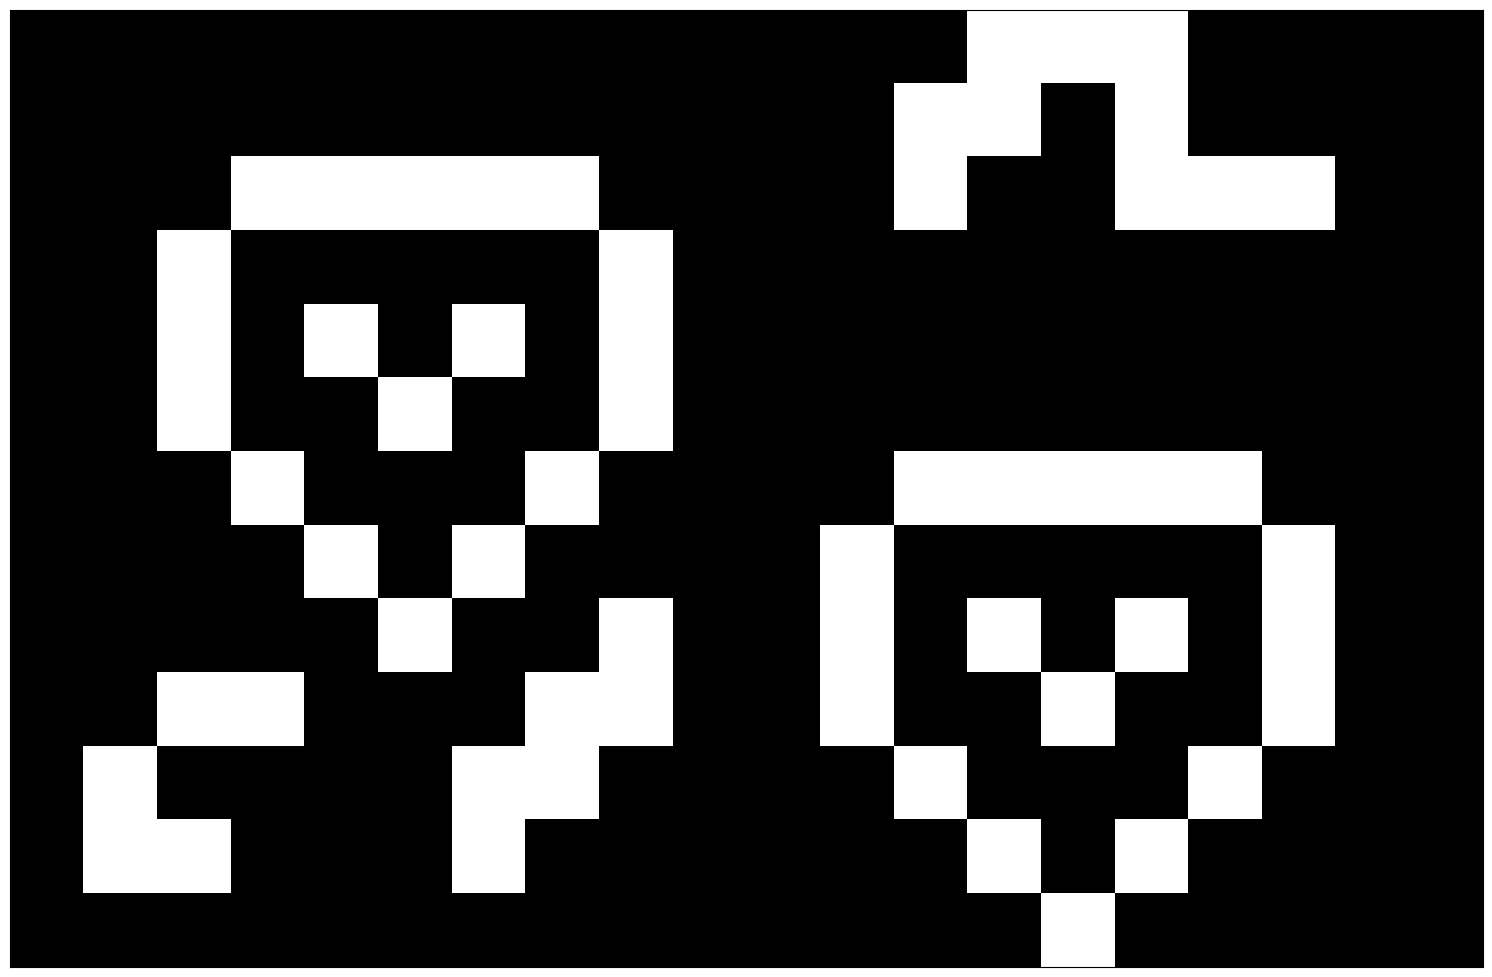

In [70]:
img_pattern = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    ],
    np.uint8,
)
h_color(img_pattern)


Let us define such a pattern as a structuring element.

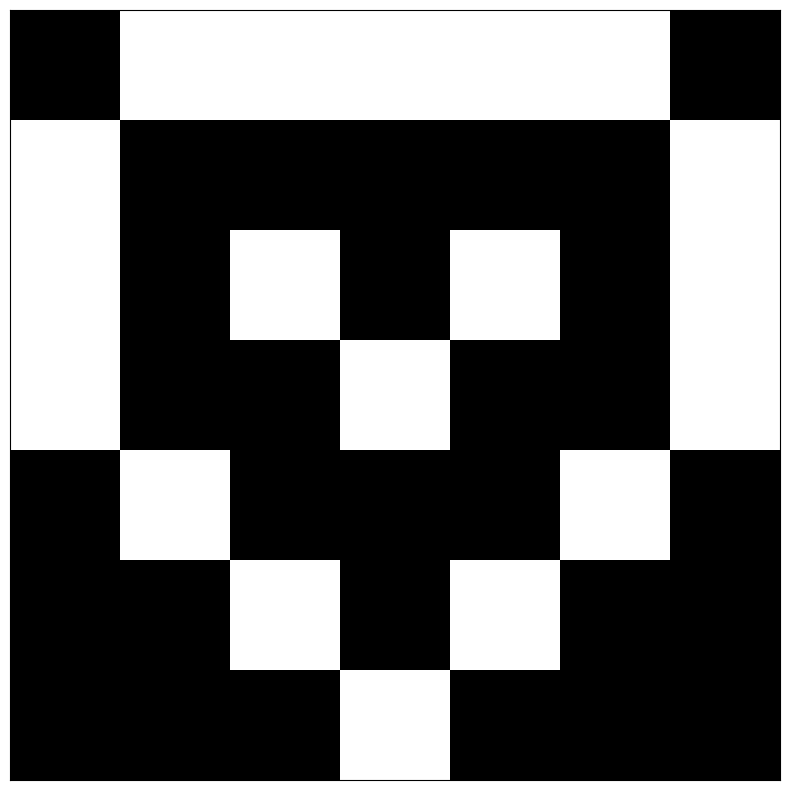

In [71]:
struct = np.array(
    [
        [0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ],
    np.uint8,
)
h_color(struct)


**The expected result of erosion of the input image and the structured object will be a bitmask, with the pixels switch on at the positions where the structuring object is found.**

(0) object found at position (5, 5)
(1) object found at position (9, 14)


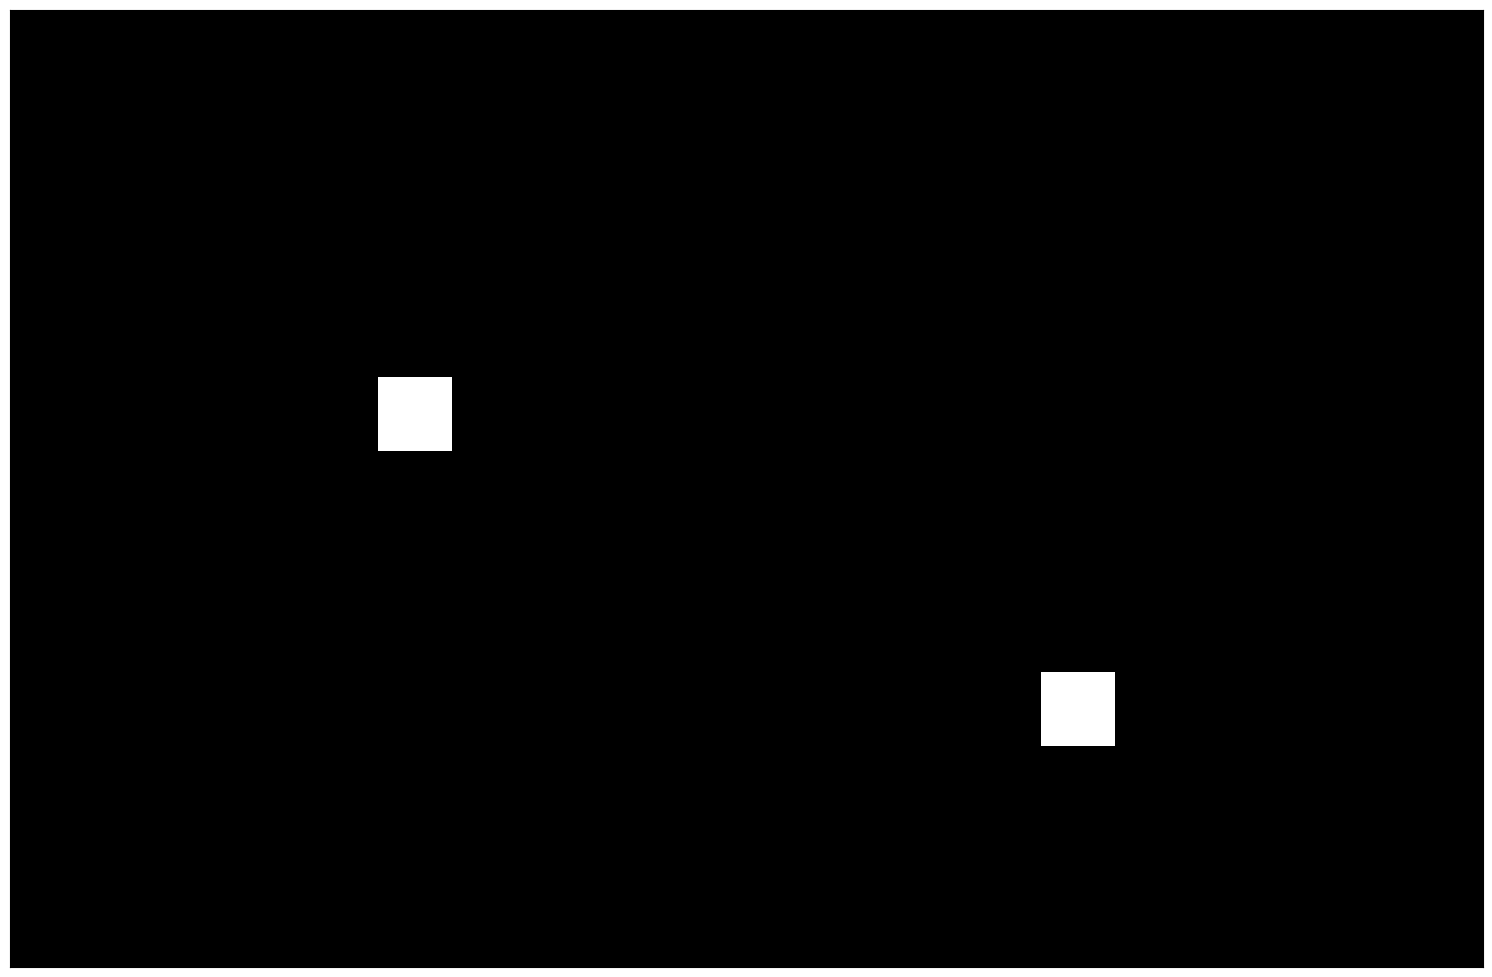

In [72]:
img_pattern_recognition = cv2.erode(img_pattern, struct, iterations=1)

for i, xy in enumerate(zip(*np.where(img_pattern_recognition))):
    print(f"({i}) object found at position {xy}")

h_color(img_pattern_recognition)


Moreover, a structural element can also come from the image itself - you can imagine a situation where we take neighborhoods of all pixels and take the most frequently appearing element. This way we can create a simple **image descriptor** and use it in processing **other images**.

# Other applications of morphological operations

Morphological operations can be used to find the **contour, convex hull, skeleton**, centroid of an object or also **separating overlapping areas** or cleaning up edges.





## Distance transform

**Distance transform** its purpose is to give for each pixel of the object the distance to the nearest edge of the object.

There are many algorithms for its determination depending on the metric adopted. The simplest way is to perform iterative erosions and record in which iteration a given pixel was removed, or count for how many iterations a pixel stayed on.

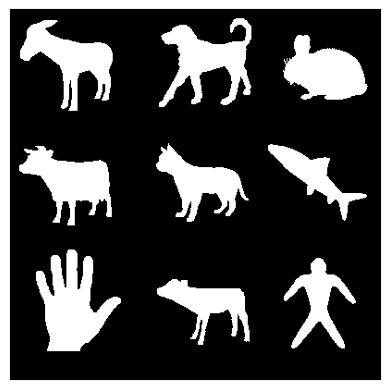

In [73]:
img_animal_raw = cv2.imread("./binary_images.png", 0)
img_animal = ((img_animal_raw>0)*1).astype(np.uint8)
show_binary(img_animal)

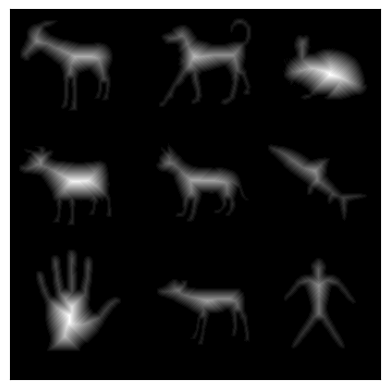

In [74]:
img_animal_raw = cv2.imread("./binary_images.png", 0)
img_animal = ((img_animal_raw>0)*1).astype(np.uint8)
img_counter = np.zeros_like(img_animal).astype(np.int32)
struct = np.ones((3, 3), np.uint8)
while np.any(img_animal):
    img_counter += img_animal
    img_animal = cv2.erode(img_animal, struct, iterations=1)


show_binary(img_counter)

## Hit or miss transform

**Hit or miss transform** is a general binary morphological operation that can be used to look for particular patterns. It is analogous to an erosion operation with a structural element $S$.

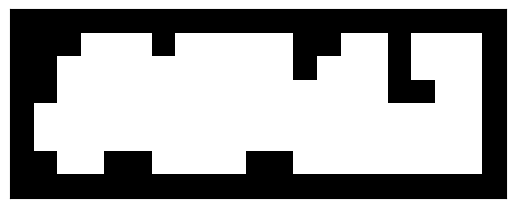

Structuring element hit:


0,0,0
0,1,1
1,1,1


Structuring element miss:


1,1,1
0,0,0
0,0,0


Structuring element from Task 1:


-1,-1,-1
0,1,1
1,1,1


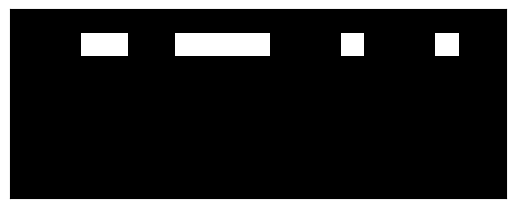

In [75]:
img_bin = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    np.uint8,
)

show_binary(img_bin)

struct_hit = np.array([[0, 0, 0], [0, 1, 1], [1, 1, 1]])
struct_miss = np.array([[1, 1, 1], [0, 0, 0], [0, 0, 0]])

print("Structuring element hit:")
h(struct_hit)
print("Structuring element miss:")
h(struct_miss)

print("Structuring element from Task 1:")
h(np.array([[-1, -1, -1], [0, 1, 1], [1, 1, 1]]))

img_bin = binary_hit_or_miss(img_bin, struct_hit, struct_miss)

show_binary(img_bin)

## Skeletonize

**Thinning** is the operation of removing selected pixels from the original image:

$$Thinning = I \cap \neg hit\_or\_miss(I,S)$$

**Skeletonization** is a fundamental image processing technique that aims to distill the essential structural characteristics of a binary image while discarding the majority of foreground pixels. This process involves extracting a skeletal representation, preserving the original region's extent and connectivity. The skeleton is a reduced and refined version of the original figure. It is defined by points equidistant from at least two points along the figure's boundary, making it significantly smaller yet faithfully encapsulating the fundamental topological properties of the original shape.

Finding a skeleton is an iterative process where in each iteration we perform image thinning with structural element $s_1$ and then with $s_2$:

$$s_1 = \begin{bmatrix}
-1 & -1 & -1\\
 0  & 1  & 0\\
 1  & 1  & 1\\
\end{bmatrix}$$

$$s_2 = \begin{bmatrix}
 0 & -1 & -1\\
 1  & 1  & -1\\
 0  & 1  & 0\\
\end{bmatrix}$$

In the next iteration, both of these structural elements are rotated by 90 degrees.
We perform these operations as long as there are changes in the images between successive iterations with the same structural element (after 4 rotations of 90 degrees).


The skeleton can also be determined using the distance transform.

## Task 3

Implement a function that will skeletonize the binary input image

**Note:** to rotate structural elements can be used np.rot90.

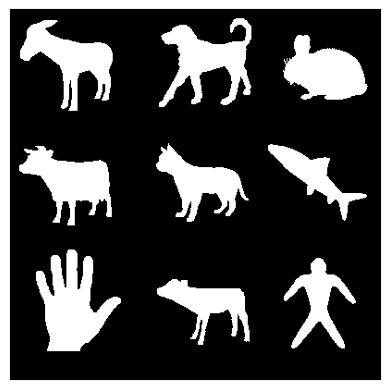

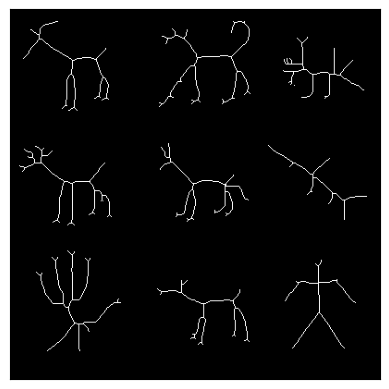

In [80]:
img_animal_raw = cv2.imread("./binary_images.png", 0)
# img_animal = img_animal_raw < 255
img_animal = ((img_animal_raw>0)*1).astype(np.uint8)
show_binary(img_animal)


def skeletonize(img):
    s1 = np.array([[-1, -1, -1], 
                   [0, 1, 0], 
                   [1, 1, 1]], dtype = np.int8)
    s2 = np.array([[0, -1, -1], 
                   [1, 1, -1], 
                   [0, 1, 0]], dtype = np.int8)
    skeleton = np.copy(img)
    
    change = True
    while change:
        change = False
        for i in range(4):
            thin1 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s1)
            thin1 = np.logical_and(skeleton, np.logical_not(thin1))
            if not np.array_equal(thin1, skeleton):
                change = True
            skeleton = thin1
            
            thin2 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s2)
            thin2 = np.logical_and(skeleton, np.logical_not(thin2))
            if not np.array_equal(thin2, skeleton):
                change = True
            skeleton = thin2
                        
            s1 = np.rot90(s1)
            s2 = np.rot90(s2)
        
    
    return skeleton


skeleton = skeletonize(img_animal)
show_binary(skeleton)

# Grayscale  morphology operations

## Morphology operations as min max functions

Erosion and dilation operations have their interpretation in the continuous domain. Let us analyze the case of erosion and dilation for a binary image, introduced earlier for task 1 (s - structuring element, I - input image, d - matching matrix):

$$s = \begin{bmatrix}
0 & 1 & 0\\
1 & -1 & 1\\
-1 & 0 & -1\\
\end{bmatrix}$$

$$I = \begin{bmatrix}
0 & 0 & 0\\
1 & 1 & 1\\
0 & 1 & 0\\
\end{bmatrix}$$

$$d = \begin{bmatrix}
1 & 0 & 1\\
1 & 0 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$

We have defined a situation in which the dilation returns the value 1, as a situation in which any element of the matching matrix equals 1. To implement such an operation, you can perform: **max(d)**, so if the largest value is 1. We can see that the $ max (d) $ operation will return 1 when **any element of the d matrix is 1**.

Likewise, erosion will return 1 when all elements of the d matrix are equal to 1. In other words, erosion performs the **min(d)** operation.




In [ ]:
image = np.array(
    [[0, 1, 2, 3, 2, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 2, 1, 0]]
).astype(np.uint8)
print("Input image")
print(image)
struct = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]]).astype(np.uint8)
print("\nStructuring element")
print(struct)
img_dil = cv2.dilate(image, struct, iterations=1)
img_ero = cv2.erode(image, struct, iterations=1)
print("\nImage after dilation")
print(img_dil)
print("\nImage after erosion")
print(img_ero)


In [ ]:
img_space_raw = cv2.imread("./supernova.png", 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)

struct = np.ones([5, 5], np.uint8)

img_space_dil = cv2.dilate(img_space_raw, struct, iterations=1)
img_space_ero = cv2.erode(img_space_raw, struct, iterations=1)

imshow(np.concatenate([img_space_raw, img_space_dil, img_space_ero], 1))


## Continuous morphology in terms of functions

For operations defined in this way, we can introduce erosions and dilations as a **continuous morphology in terms of functions** as:

$$(I \oplus s)(x, y) = \max\{I(x - a, y - b) + s(a, b) : (x - a, y - b) \in D_I, (a, b) \in D_s\}$$

$$(I \ominus s)(x, y) = \min\{I(x - a, y - b) - s(a, b) : (x - a, y - b) \in D_I, (a, b) \in D_s\}$$

where:
* $\oplus$ - dilation,
* $\ominus$ - erosion,

* $D_I$ - image domain (i.e. all positions of pixels, if a pixel does not belong to $ D_I $ it means that it goes beyond the image area)

* $D_s$ - domain of structuring element,
* $a, b$ - shifts that carry out the operation of applying a structuring element to the image.
* s - structuring element where $s(a,b) \in R$

Example:

In [ ]:
img_space_raw = cv2.imread("./supernova.jpg", 0)
img_space_raw = cv2.resize(img_space_raw, None, fx=0.5, fy=0.5)

struct_bin = np.ones([5, 5], np.uint8)
struct_float = np.array([[0.1, 0.5, 0.1], [0.5, 0.8, 0.5], [0.1, 0.5, 0.1]])

# TODO:
raise NotImplementedError()

img_space_dil_bin = dilate_f_bin(img_space_raw, struct_bin)
img_space_ero_bin = erode_f_bin(img_space_raw, struct_bin)
img_space_dil_float = dilate_f(img_space_raw, struct_float)
img_space_ero_float = erode_f(img_space_raw, struct_float)

print("\nResult of morphological operations for a binary structuring element\n")
imshow(np.concatenate([img_space_raw, img_space_dil_bin, img_space_ero_bin], 1))

print("\nResult of morphological operations for a floating point structuring element\n")
imshow(np.concatenate([img_space_raw, img_space_dil_float, img_space_ero_float], 1))
